In [1]:
import pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import time
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
#from keras.utils import to_categorical
import feather
import random
from datetime import *

import warnings
warnings.filterwarnings("ignore")


C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
FILENAME = "Datasets/final_datasets/merged_data"

In [16]:
data = feather.read_dataframe(f"{FILENAME}.feather")

In [17]:
# Remove those one-hot encoded columns in the dataset created by Abhi

def in_name(c, one_hots):
    for col_name in one_hots:
        if c.startswith(f"{col_name}_"):
            return True
    return False

one_hots = ['Wind_Direction', 'Timezone','State', 'Weather_Condition']
remove = [col for col in data.columns if in_name(col, one_hots)]
data = data.drop(remove, axis=1)

In [18]:
# Remove missing values
data = data.dropna().reset_index(drop=True)

In [19]:
# Get the grouped severity

data['Severity'] = data['Severity'].astype(int)
data['Grouped_Severity'] = np.where(data['Severity']<=2, 0, 1)
data = data.drop('Severity', axis=1)

# Clean categorical features

### Clean wind direction

* "CALM" = ["Calm", "CALM"]
* "W" = ["W", "West", "WSW", "WNW"] 
* "S" = ["S", "South", "SSW", "SSE"] 
* "N" = ["N", "North", "NNW", "NNE"] 
* "E" = ["E", "East", "ESE", "ENE"]
* "VAR" = ["VAR", "Variable"]

In [20]:
data.loc[data['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
data.loc[(data['Wind_Direction']=='West')|(data['Wind_Direction']=='WSW')|(data['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
data.loc[(data['Wind_Direction']=='South')|(data['Wind_Direction']=='SSW')|(data['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
data.loc[(data['Wind_Direction']=='North')|(data['Wind_Direction']=='NNW')|(data['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
data.loc[(data['Wind_Direction']=='East')|(data['Wind_Direction']=='ESE')|(data['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
data.loc[data['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", data['Wind_Direction'].unique())

Wind Direction after simplification:  ['SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' 'CALM']


### Clean weather condition

In [21]:
Counter(data['Weather_Condition'])

Counter({'Overcast': 314137,
         'Mostly Cloudy': 432506,
         'Light Rain': 150052,
         'Light Snow': 46407,
         'Haze': 29015,
         'Scattered Clouds': 170312,
         'Partly Cloudy': 306197,
         'Clear': 597336,
         'Snow': 5176,
         'Light Freezing Drizzle': 716,
         'Fog': 24155,
         'Shallow Fog': 710,
         'Rain': 32900,
         'Heavy Rain': 13063,
         'Light Freezing Rain': 1800,
         'Cloudy': 205447,
         'Smoke': 2831,
         'Patches of Fog': 1487,
         'Mist': 1395,
         'Light Freezing Fog': 478,
         'Light Thunderstorms and Rain': 3807,
         'Light Drizzle': 9415,
         'Thunderstorms and Rain': 1620,
         'Fair': 523539,
         'Blowing Dust / Windy': 115,
         'Widespread Dust': 147,
         'Fair / Windy': 7741,
         'Drizzle': 1197,
         'Light Rain / Windy': 1991,
         'Heavy Drizzle': 162,
         'Showers in the Vicinity': 238,
         'Light Rain wi

https://www.timeanddate.com/weather/glossary.html <br>

**Create features according the different weather conditions** <br>
Scattered clouds, partly cloudy = PARTLY CLOUDY <br>
Overcast, Mostly cloudly, Cloudy = CLOUDY <br>
Fair, Clear = CLEAR <br>
Snow (light snow, heavy snow), and wintry mix  = SNOW <br>
drizzle, light rain/drizzle, light freezing rain/drizzle = LIGHT RAIN <br>
Heavy Rain, heavy thunderstorms, heavy t-storm = HEAVY RAIN <br>
Haze, fog, mist, smoke = fog     *(see https://www.worldatlas.com/articles/what-are-the-differences-between-mist-haze-and-fog.html)*<br>
Rain, light thunderstorms, thunderstorms, t-storm, thunder = RAIN <br>

In [22]:
conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Light Snow', 'Heavy Snow', 'Snow',
              'Heavy Rain', 'Heavy Thunderstorm', 'Thunderstorm', 'Light Rain',  'Rain', 
              'Fog'] 

def get_condition(string, conditions):
    strings = [['clear', 'fair'],
               ['partly cloudy', 'scattered clouds'],
               ['overcast', 'mostly cloudy', 'cloudy'],
               ['light snow', 'light ice', 'wintry mix'],
               ['heavy snow', 'blowing snow'],
               ['snow'],
               ['heavy rain', 'heavy drizzle'],
               ['heavy thunderstorms', 'heavy t-storm'],
               ['thunder', 't-storm'],
               ['drizzle', 'light rain', 'light freezing rain'],
               ['rain', 'thunderstorms', 't-storm', 'thunder', 'showers'],
               ['fog', 'haze', 'mist', 'smoke']]

    for j, k in enumerate(strings):
        for val in k:
            if val in string.lower():
                return conditions[j]
    return 'Others'

In [23]:
res = []
for i in data['Weather_Condition'].values:
    res.append(get_condition(i, conditions))

data['Condition'] = res

for i in conditions+['Others']:
    print(i, ":")
    print(set(data[data['Condition']==i]['Weather_Condition']))
    print(sum(data['Condition']==i))
    print("\n")
    
data = data[data['Condition']!='Others']

Clear :
{'Fair', 'Clear', 'Fair / Windy'}
1128616


Partly Cloudy :
{'Partly Cloudy', 'Scattered Clouds', 'Partly Cloudy / Windy'}
479226


Cloudy :
{'Cloudy', 'Overcast', 'Mostly Cloudy', 'Cloudy / Windy', 'Mostly Cloudy / Windy'}
960533


Light Snow :
{'Wintry Mix', 'Light Ice Pellets', 'Light Snow', 'Light Snow / Windy'}
49183


Heavy Snow :
{'Blowing Snow', 'Heavy Snow'}
1657


Snow :
{'Snow', 'Snow / Windy'}
5288


Heavy Rain :
{'Heavy Drizzle', 'Heavy Rain / Windy', 'Heavy Rain'}
13516


Heavy Thunderstorm :
{'Heavy T-Storm / Windy', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain'}
4088


Thunderstorm :
{'T-Storm', 'Thunderstorm', 'Thunder', 'Thunderstorms and Rain', 'Light Thunderstorms and Rain', 'Light Rain with Thunder', 'T-Storm / Windy', 'Thunder / Windy', 'Thunder in the Vicinity'}
20548


Light Rain :
{'Drizzle', 'Light Freezing Drizzle', 'Light Rain', 'Drizzle and Fog', 'Light Rain / Windy', 'Light Freezing Rain', 'Light Drizzle'}
165300


Rain :
{'Rain', 'Showers in the

In [24]:
# Save this dataframe
data = data.reset_index(drop = True)
data.to_feather("{}_v1.feather".format(FILENAME))

# Correlation for numeric attributes

In [25]:
data = feather.read_dataframe("{}_v1.feather".format(FILENAME))

### NOTE: At this point we already did some basic outlier removal in previous files

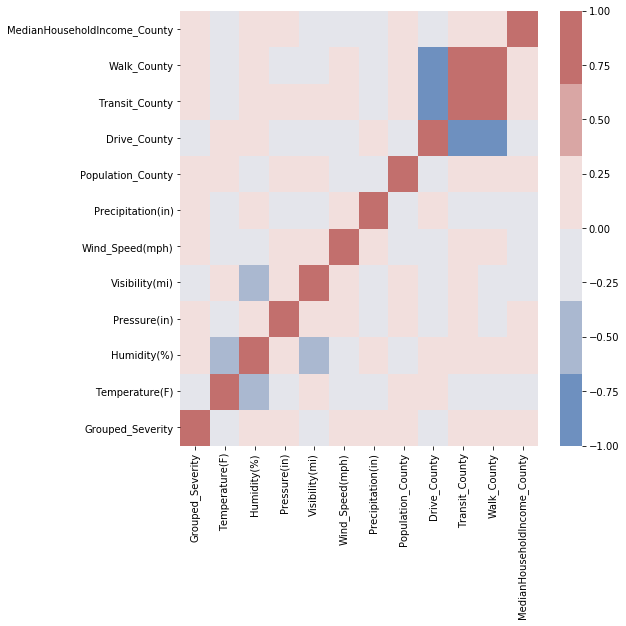

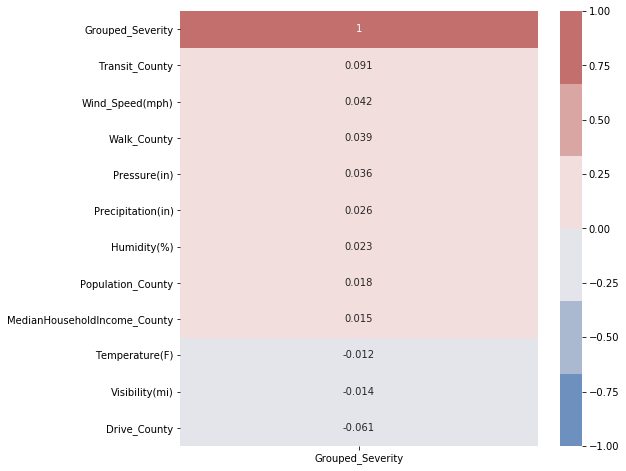

In [27]:
cols = ['Grouped_Severity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

plt.figure(figsize=(8,8))
ax = sns.heatmap(data[cols].corr(),
 vmax=1, vmin=-1, cmap=sns.color_palette("vlag"));
ax.invert_yaxis()
plt.show()


plt.figure(figsize=(8,8))
ax = sns.heatmap(data[cols].corr()[['Grouped_Severity']].sort_values('Grouped_Severity'),
 vmax=1, vmin=-1, cmap=sns.color_palette("vlag"), annot=True);
ax.invert_yaxis()
plt.show()

# Feature engineering

### Create hour, weekend, and month attributes

In [28]:
data['Start_Time'] = pd.to_datetime(data['Start_Time'])

data['Hour'] = data['Start_Time'].dt.hour
data['Weekday'] = data['Start_Time'].dt.weekday
data['Month'] = data['Start_Time'].dt.month

# Chi Square Categorical Attributes

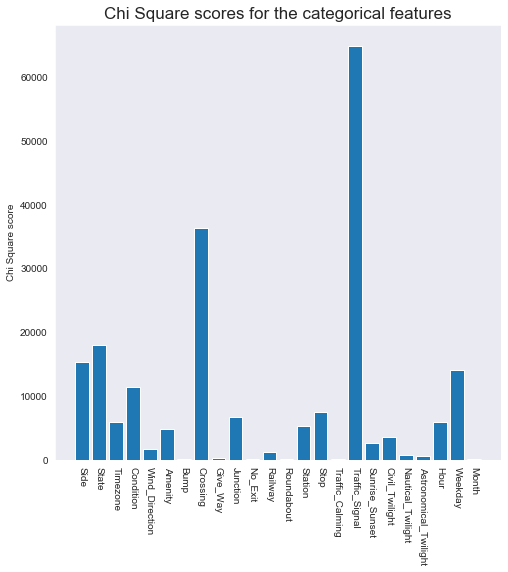

In [29]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

col_names = ['Side', 'State', 'Timezone', 'Condition', 'Wind_Direction',
             'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 
             'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 
             'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
             'Hour', 'Weekday', 'Month'
            ]
X_train, X_test, y_train, y_test = train_test_split(data[col_names],
                                                    data['Grouped_Severity'], test_size=0.33, random_state=30034)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features

# for i in range(len(fs.scores_)):
#     print(f"{col_names[i]}: {fs.scores_[i]}")

sns.set_style("dark")
plt.figure(figsize=(8,8))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(range(len(col_names)), col_names, rotation=270)
plt.ylabel('Chi Square score')
plt.title("Chi Square scores for the categorical features", fontsize=17)
plt.show()

# Save the dataset

In [30]:
one_hots = ['Timezone', 'Wind_Direction','State', 'Condition', 'Hour', 'Weekday']
oh = pd.DataFrame()
for c in one_hots:
    dummies = pd.get_dummies(data[c], prefix=c)
    oh = pd.concat([oh, dummies], axis=1)

data = pd.concat([data, oh], axis=1)

In [31]:
# Remove those logical/categorical attributes that seem irrelevant + any irrelevant attributes

drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'Distance(mi)', 
        'County', 'City', 'Airport_Code', 'State', 
        'Wind_Direction', 'Timezone', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Railway', 'Roundabout', 'Give_Way', 'Traffic_Calming',
        'Nautical_Twilight', 'Astronomical_Twilight',
        'Hour', 'Weekday', 'Month']

data = data.drop(drop, axis=1).reset_index(drop=True)

In [32]:
# Save this dataframe
data = data.reset_index(drop = True)
data.to_feather("{}_v1.feather".format(FILENAME))

#### With numeric attributes

In [33]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
data = feather.read_dataframe("{}_v1.feather".format(FILENAME))
data.to_feather("{}_numeric_v2.feather".format(FILENAME))
del(data)

#### without numeric attributes

In [34]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
data = feather.read_dataframe("{}_v1.feather".format(FILENAME))
num_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

data = data.drop(num_cols, axis=1).reset_index(drop=True)

# Convert to feather file format
data.to_feather("{}_v2.feather".format(FILENAME))

# Clear memory
del(data)

# Model

In [4]:
# Model Function
def Neural_Network(X,labels,neuron_size,epoch_size,k_folds):
    scaler=MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=k_folds, random_state=30034, shuffle=True)

    fold_no = 1
    accs = []  # store each accuracy


    for train_index, test_index in skf.split(X, labels):

        # One hot encode labels
        print("FOLD NUMBER = ", str(fold_no))


        X_train = X[train_index]
        X_test = X[test_index]

        y_train = labels[train_index]
        y_test = labels[test_index]

        EPOCHS = epoch_size
        BATCH_SIZE = 128


        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(neuron_size,input_dim=X_train.shape[1], activation='relu'))
        model.add(tf.keras.layers.Dense(int(2/3*neuron_size), activation=tf.nn.leaky_relu))
        model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
        # Compile model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
        
        y_preds = model.predict(X_test)
        p = []
        for i in y_preds:
            p.append(np.argmax(i))

        test_acc = accuracy_score(y_test, p)
        accs.append(test_acc)
        
        print("\nTest Accuracy:", test_acc)

        cm=confusion_matrix(y_test,p)
        cm = pd.DataFrame(cm, index = [i for i in "01"],
                          columns = [i for i in "01"])
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        sns.heatmap(cm, annot=True, 
                    cmap='Blues', cbar=False)
        plt.show()

        print("============================================")
        fold_no+=1

    return accs

### Model evaluation with numeric

FOLD NUMBER =  1
Epoch 1/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.5128 - acc: 0.7322
Epoch 2/10
2337448/2337448 [==============================] - 15s 7us/sample - loss: 0.5010 - acc: 0.7403
Epoch 3/10
2337448/2337448 [==============================] - 15s 7us/sample - loss: 0.4952 - acc: 0.7448
Epoch 4/10
2337448/2337448 [==============================] - 15s 7us/sample - loss: 0.4919 - acc: 0.7473
Epoch 5/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4897 - acc: 0.7488
Epoch 6/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4879 - acc: 0.7498
Epoch 7/10
2337448/2337448 [==============================] - 15s 7us/sample - loss: 0.4864 - acc: 0.7509
Epoch 8/10
2337448/2337448 [==============================] - 15s 7us/sample - loss: 0.4852 - acc: 0.7520
Epoch 9/10
2337448/2337448 [==============================] - 15s 7us/sample - loss: 0.4841 - acc: 0.7525
Epoch 10/10
2337448/2337448 [

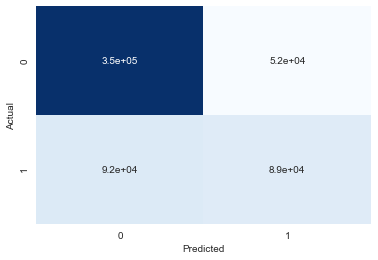

FOLD NUMBER =  2
Epoch 1/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.5131 - acc: 0.7322
Epoch 2/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.5009 - acc: 0.7410
Epoch 3/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4953 - acc: 0.7450
Epoch 4/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4917 - acc: 0.7476
Epoch 5/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4889 - acc: 0.7494
Epoch 6/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4869 - acc: 0.7509
Epoch 7/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4854 - acc: 0.7518
Epoch 8/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4843 - acc: 0.7526
Epoch 9/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4834 - acc: 0.7532
Epoch 10/10
2337448/2337448 [

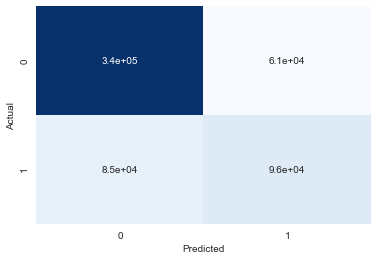

FOLD NUMBER =  3
Epoch 1/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.5125 - acc: 0.7322
Epoch 2/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4999 - acc: 0.7413
Epoch 3/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4944 - acc: 0.7456
Epoch 4/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4907 - acc: 0.7479
Epoch 5/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4884 - acc: 0.7497
Epoch 6/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4865 - acc: 0.7511
Epoch 7/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4851 - acc: 0.7522
Epoch 8/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4840 - acc: 0.7529
Epoch 9/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4830 - acc: 0.7534
Epoch 10/10
2337448/2337448 [

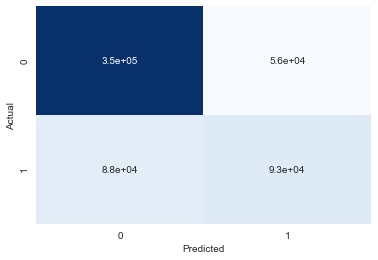

FOLD NUMBER =  4
Epoch 1/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.5130 - acc: 0.7316
Epoch 2/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.5007 - acc: 0.7409
Epoch 3/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.4946 - acc: 0.7452
Epoch 4/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4912 - acc: 0.7477
Epoch 5/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4888 - acc: 0.7494
Epoch 6/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4869 - acc: 0.7508
Epoch 7/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4854 - acc: 0.7518
Epoch 8/10
2337448/2337448 [==============================] - 16s 7us/sample - loss: 0.4842 - acc: 0.7523
Epoch 9/10
2337448/2337448 [==============================] - 17s 7us/sample - loss: 0.4833 - acc: 0.7532
Epoch 10/10
2337448/2337448 [

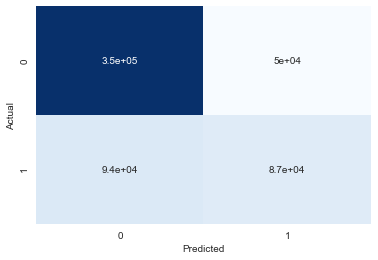

FOLD NUMBER =  5
Epoch 1/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5128 - acc: 0.7321
Epoch 2/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.4996 - acc: 0.7415
Epoch 3/10
2337448/2337448 [==============================] - 18s 7us/sample - loss: 0.4947 - acc: 0.7453
Epoch 4/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.4913 - acc: 0.7474
Epoch 5/10
2337448/2337448 [==============================] - 20s 8us/sample - loss: 0.4887 - acc: 0.7493
Epoch 6/10
2337448/2337448 [==============================] - 20s 8us/sample - loss: 0.4870 - acc: 0.7506
Epoch 7/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.4855 - acc: 0.7517
Epoch 8/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.4842 - acc: 0.7527
Epoch 9/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.4832 - acc: 0.7531
Epoch 10/10
2337448/2337448 [

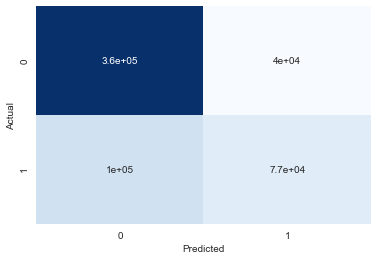

Fold  1  Accuracy:  0.7526036942853916
Fold  2  Accuracy:  0.7501976514557757
Fold  3  Accuracy:  0.7526036942853916
Fold  4  Accuracy:  0.7535654269100318
Fold  5  Accuracy:  0.752971616908697
Average Accuracy:  0.7523884167690575


In [38]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))
y = data['Grouped_Severity']
X = data.drop(["Grouped_Severity"], axis=1)

accuracies = Neural_Network(X,y,90,10,5)
for i in range(1,6):
    print("Fold ",i," Accuracy: ",accuracies[i-1])
print("Average Accuracy: ",np.mean(accuracies))

### Model evaluation without numeric

FOLD NUMBER =  1
Epoch 1/10
2337448/2337448 [==============================] - 20s 8us/sample - loss: 0.5227 - acc: 0.7271
Epoch 2/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5177 - acc: 0.7305
Epoch 3/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5165 - acc: 0.7311
Epoch 4/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5157 - acc: 0.7315
Epoch 5/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5152 - acc: 0.7318
Epoch 6/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5147 - acc: 0.7322
Epoch 7/10
2337448/2337448 [==============================] - 20s 9us/sample - loss: 0.5144 - acc: 0.7325
Epoch 8/10
2337448/2337448 [==============================] - 21s 9us/sample - loss: 0.5141 - acc: 0.7326
Epoch 9/10
2337448/2337448 [==============================] - 20s 9us/sample - loss: 0.5139 - acc: 0.7326
Epoch 10/10
2337448/2337448 [

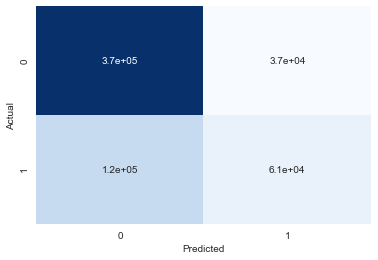

FOLD NUMBER =  2
Epoch 1/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5227 - acc: 0.7272
Epoch 2/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5178 - acc: 0.7304
Epoch 3/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5165 - acc: 0.7311
Epoch 4/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5158 - acc: 0.7317
Epoch 5/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5152 - acc: 0.7320
Epoch 6/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5148 - acc: 0.7322
Epoch 7/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5145 - acc: 0.7324
Epoch 8/10
2337448/2337448 [==============================] - 20s 9us/sample - loss: 0.5142 - acc: 0.7326
Epoch 9/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5140 - acc: 0.7328
Epoch 10/10
2337448/2337448 [

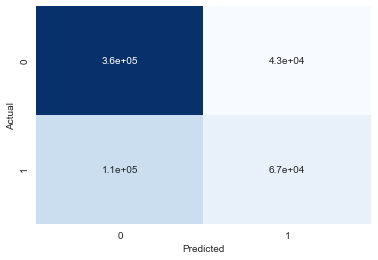

FOLD NUMBER =  3
Epoch 1/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5226 - acc: 0.7275
Epoch 2/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5178 - acc: 0.7306
Epoch 3/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5166 - acc: 0.7315
Epoch 4/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5159 - acc: 0.7319
Epoch 5/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5153 - acc: 0.7320
Epoch 6/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5149 - acc: 0.7324
Epoch 7/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5146 - acc: 0.7327
Epoch 8/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5143 - acc: 0.7327
Epoch 9/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5141 - acc: 0.7329
Epoch 10/10
2337448/2337448 [

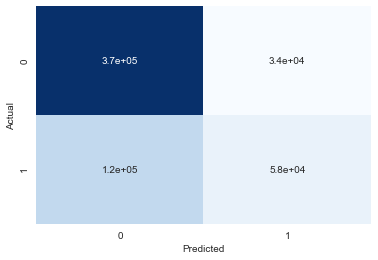

FOLD NUMBER =  4
Epoch 1/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5228 - acc: 0.7272
Epoch 2/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5179 - acc: 0.7304
Epoch 3/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5167 - acc: 0.7309
Epoch 4/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5159 - acc: 0.7316
Epoch 5/10
2337448/2337448 [==============================] - 20s 8us/sample - loss: 0.5154 - acc: 0.7318
Epoch 6/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5150 - acc: 0.7321
Epoch 7/10
2337448/2337448 [==============================] - 18s 8us/sample - loss: 0.5146 - acc: 0.7325
Epoch 8/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5143 - acc: 0.7326
Epoch 9/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5141 - acc: 0.7327
Epoch 10/10
2337448/2337448 [

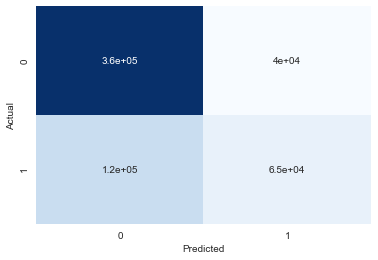

FOLD NUMBER =  5
Epoch 1/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5230 - acc: 0.7268
Epoch 2/10
2337448/2337448 [==============================] - 20s 8us/sample - loss: 0.5182 - acc: 0.7300
Epoch 3/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5170 - acc: 0.7308
Epoch 4/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5162 - acc: 0.7315
Epoch 5/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5156 - acc: 0.7318
Epoch 6/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5152 - acc: 0.7319
Epoch 7/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5148 - acc: 0.7322
Epoch 8/10
2337448/2337448 [==============================] - 20s 9us/sample - loss: 0.5146 - acc: 0.7324
Epoch 9/10
2337448/2337448 [==============================] - 19s 8us/sample - loss: 0.5143 - acc: 0.7328
Epoch 10/10
2337448/2337448 [

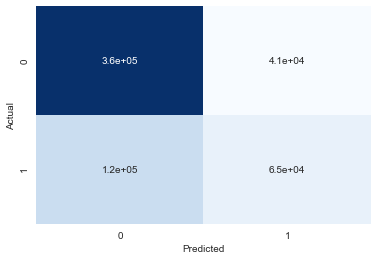

Fold  1  Accuracy:  0.7312487807215391
Fold  2  Accuracy:  0.7308158299136495
Fold  3  Accuracy:  0.730923639798618
Fold  4  Accuracy:  0.7314489990793378
Fold  5  Accuracy:  0.7323337246432862
Average Accuracy:  0.731354194831286


In [39]:
data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
y = data['Grouped_Severity']
X = data.drop(["Grouped_Severity"], axis=1)

accuracies = Neural_Network(X,y,90,10,5)
for i in range(1,6):
    print("Fold ",i," Accuracy: ",accuracies[i-1])
print("Average Accuracy: ",np.mean(accuracies))

### Finding best neuron size

Neuron Size:  125
Epoch 1/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.5139 - acc: 0.7313
Epoch 2/5
1957612/1957612 [==============================] - 17s 9us/sample - loss: 0.5020 - acc: 0.7400
Epoch 3/5
1957612/1957612 [==============================] - 17s 8us/sample - loss: 0.4957 - acc: 0.7445
Epoch 4/5
1957612/1957612 [==============================] - 18s 9us/sample - loss: 0.4920 - acc: 0.7473
Epoch 5/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.4893 - acc: 0.7489

Test Accuracy: 0.7494269849138869


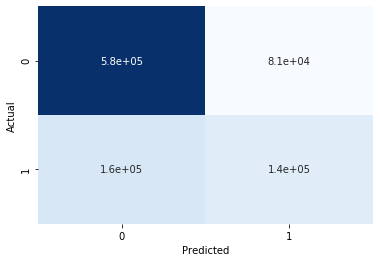

Neuron Size:  105
Epoch 1/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.5142 - acc: 0.7313
Epoch 2/5
1957612/1957612 [==============================] - 17s 9us/sample - loss: 0.5023 - acc: 0.7397
Epoch 3/5
1957612/1957612 [==============================] - 17s 8us/sample - loss: 0.4963 - acc: 0.7439
Epoch 4/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.4921 - acc: 0.7467
Epoch 5/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.4894 - acc: 0.7486

Test Accuracy: 0.7470643996357594


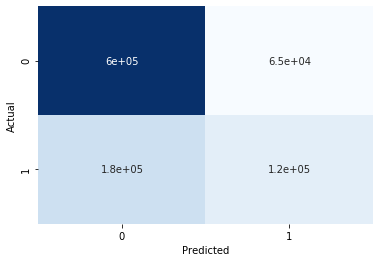

Neuron Size:  85
Epoch 1/5
1957612/1957612 [==============================] - 17s 8us/sample - loss: 0.5150 - acc: 0.7305
Epoch 2/5
1957612/1957612 [==============================] - 17s 8us/sample - loss: 0.5027 - acc: 0.7393
Epoch 3/5
1957612/1957612 [==============================] - 17s 9us/sample - loss: 0.4967 - acc: 0.7437
Epoch 4/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.4926 - acc: 0.7467
Epoch 5/5
1957612/1957612 [==============================] - 15s 8us/sample - loss: 0.4899 - acc: 0.7485

Test Accuracy: 0.7481067166702274


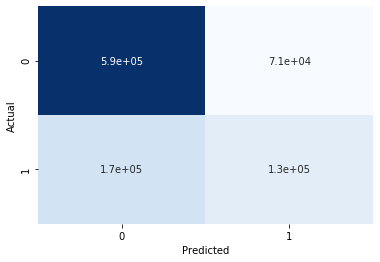

Neuron Size:  65
Epoch 1/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.5157 - acc: 0.7302
Epoch 2/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.5037 - acc: 0.7384
Epoch 3/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.4986 - acc: 0.7428
Epoch 4/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.4949 - acc: 0.7455
Epoch 5/5
1957612/1957612 [==============================] - 16s 8us/sample - loss: 0.4924 - acc: 0.7474

Test Accuracy: 0.747769648972514


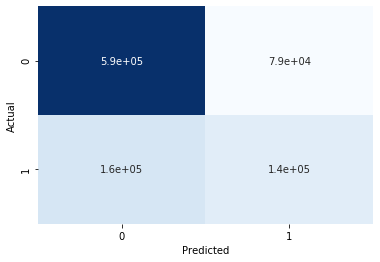

Neuron Size:  45
Epoch 1/5
1957612/1957612 [==============================] - 15s 7us/sample - loss: 0.5167 - acc: 0.7288
Epoch 2/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5053 - acc: 0.7369
Epoch 3/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5009 - acc: 0.7407
Epoch 4/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.4961 - acc: 0.7442
Epoch 5/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.4927 - acc: 0.7466

Test Accuracy: 0.7475591113028652


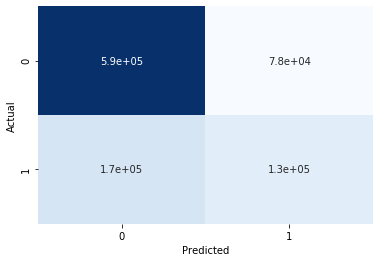

Neuron Size:  25
Epoch 1/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5182 - acc: 0.7286
Epoch 2/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5058 - acc: 0.7369
Epoch 3/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5015 - acc: 0.7405
Epoch 4/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.4987 - acc: 0.7425
Epoch 5/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.4970 - acc: 0.7436

Test Accuracy: 0.7435267445068336


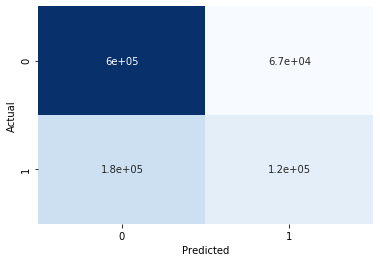

Neuron Size:  5
Epoch 1/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5288 - acc: 0.7229
Epoch 2/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5195 - acc: 0.7264
Epoch 3/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5170 - acc: 0.7283
Epoch 4/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5154 - acc: 0.7295
Epoch 5/5
1957612/1957612 [==============================] - 14s 7us/sample - loss: 0.5140 - acc: 0.7302

Test Accuracy: 0.7306621668993298


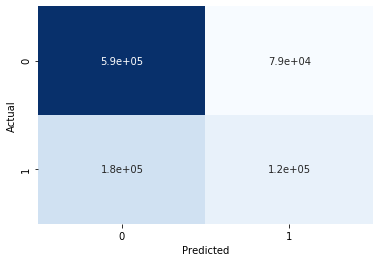

ValueError: x and y must have same first dimension, but have shapes (7,) and (10,)

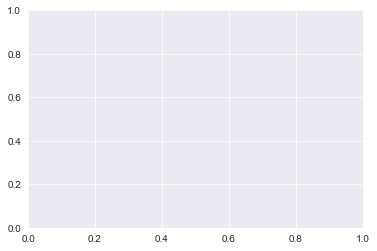

In [10]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

y = data['Grouped_Severity']
data = data.drop(["Grouped_Severity"], axis=1)
scaler=MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=30027,shuffle = True)

max_neurons = X.shape[1]
neuron_size = range(max_neurons,4,-20)

accs = []

for i in neuron_size:  
    print("==================================")
    print("Neuron Size: ", str(i))
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(i,input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(int(2/3*i), activation=tf.nn.leaky_relu))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5, batch_size=128)
        
    y_preds = model.predict(X_test)
    p = []
    for i in y_preds:
        p.append(np.argmax(i))

    test_acc = accuracy_score(y_test, p)
    accs.append(test_acc)
        
    print("\nTest Accuracy:", test_acc)
    



BEST NEURON SIZE = 125
[0.7494269849138869, 0.7470643996357594, 0.7481067166702274, 0.747769648972514, 0.7475591113028652, 0.7435267445068336, 0.7306621668993298]


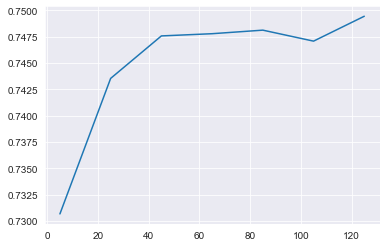

In [14]:
#plotting line graph of accuracy vs neuron_size
sns.set_style("darkgrid")
plt.plot(neuron_size, accs, label="Accuracy")
best_neuron_size = neuron_size[np.argmax(accs)]
print("\nBEST NEURON SIZE =", best_neuron_size)
print(accs)

### Performing  final evaluation

FOLD NUMBER =  1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.5121 - acc: 0.7328
Epoch 2/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.5001 - acc: 0.7411
Epoch 3/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4945 - acc: 0.7451
Epoch 4/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4911 - acc: 0.7477
Epoch 5/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4885 - acc: 0.7493
Epoch 6/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4868 - acc: 0.7505
Epoch 7/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4853 - acc: 0.7517
Epoch 8/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4842 - acc: 0.7523
Epoch 9/10
262962

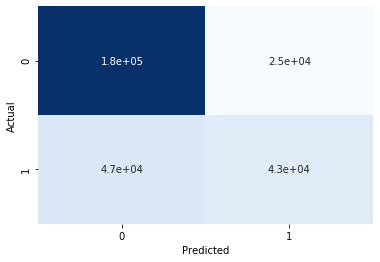

FOLD NUMBER =  2
Epoch 1/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.5123 - acc: 0.7323
Epoch 2/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4997 - acc: 0.7416
Epoch 3/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4936 - acc: 0.7460
Epoch 4/10
2629629/2629629 [==============================] - 15s 6us/sample - loss: 0.4901 - acc: 0.7484
Epoch 5/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4875 - acc: 0.7502
Epoch 6/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4858 - acc: 0.7515
Epoch 7/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4845 - acc: 0.7525
Epoch 8/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4834 - acc: 0.7532
Epoch 9/10
2629629/2629629 [==============================] - 15s 6us/sample - loss: 0.4826 - acc: 0.7540
Epoch 10/10
2629629/2629629 [

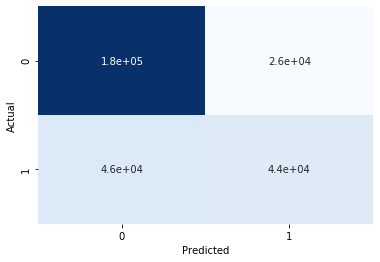

FOLD NUMBER =  3
Epoch 1/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.5122 - acc: 0.7326
Epoch 2/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.5003 - acc: 0.7416
Epoch 3/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4942 - acc: 0.7459
Epoch 4/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4904 - acc: 0.7484
Epoch 5/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4879 - acc: 0.7501
Epoch 6/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4861 - acc: 0.7514
Epoch 7/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4849 - acc: 0.7520
Epoch 8/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4837 - acc: 0.7529
Epoch 9/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4828 - acc: 0.7535
Epoch 10/10
2629629/2629629 [

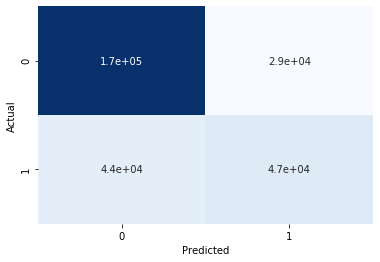

FOLD NUMBER =  4
Epoch 1/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.5122 - acc: 0.7330
Epoch 2/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.5003 - acc: 0.7411
Epoch 3/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4945 - acc: 0.7452
Epoch 4/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4909 - acc: 0.7479
Epoch 5/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4884 - acc: 0.7494
Epoch 6/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4865 - acc: 0.7508
Epoch 7/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4849 - acc: 0.7522
Epoch 8/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4838 - acc: 0.7529
Epoch 9/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4828 - acc: 0.7535
Epoch 10/10
2629629/2629629 [

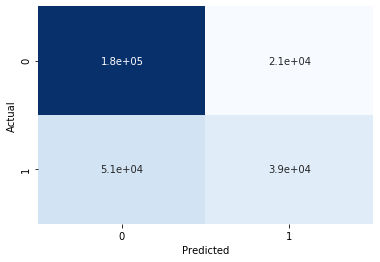

FOLD NUMBER =  5
Epoch 1/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.5121 - acc: 0.7328
Epoch 2/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4996 - acc: 0.7420
Epoch 3/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4938 - acc: 0.7461
Epoch 4/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4901 - acc: 0.7488
Epoch 5/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4875 - acc: 0.7502
Epoch 6/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4856 - acc: 0.7520
Epoch 7/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4841 - acc: 0.7528
Epoch 8/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4830 - acc: 0.7537
Epoch 9/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4821 - acc: 0.7546
Epoch 10/10
2629629/2629629 [

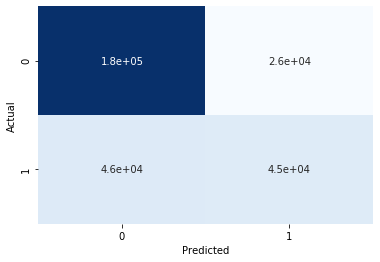

FOLD NUMBER =  6
Epoch 1/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.5120 - acc: 0.7330
Epoch 2/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4988 - acc: 0.7426
Epoch 3/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4930 - acc: 0.7468
Epoch 4/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4896 - acc: 0.7491
Epoch 5/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4873 - acc: 0.7506
Epoch 6/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4857 - acc: 0.7515
Epoch 7/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4842 - acc: 0.7525
Epoch 8/10
2629629/2629629 [==============================] - 16s 6us/sample - loss: 0.4831 - acc: 0.7532
Epoch 9/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4822 - acc: 0.7538
Epoch 10/10
2629629/2629629 [

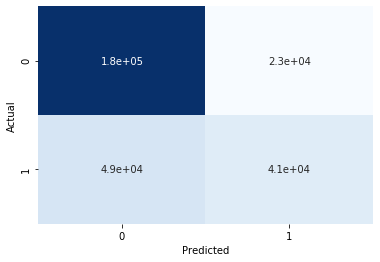

FOLD NUMBER =  7
Epoch 1/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.5126 - acc: 0.7319
Epoch 2/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.5002 - acc: 0.7412
Epoch 3/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4948 - acc: 0.7456
Epoch 4/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4914 - acc: 0.7478
Epoch 5/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4888 - acc: 0.7497
Epoch 6/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4867 - acc: 0.7514
Epoch 7/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4851 - acc: 0.7526
Epoch 8/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4838 - acc: 0.7532
Epoch 9/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4828 - acc: 0.7537
Epoch 10/10
2629629/2629629 [

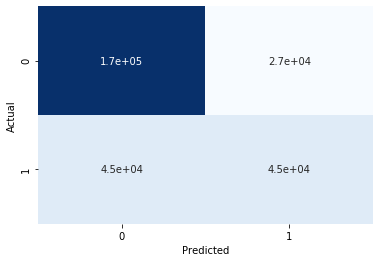

FOLD NUMBER =  8
Epoch 1/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.5126 - acc: 0.7323
Epoch 2/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4994 - acc: 0.7420
Epoch 3/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4933 - acc: 0.7460
Epoch 4/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4899 - acc: 0.7487
Epoch 5/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4879 - acc: 0.7502
Epoch 6/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4864 - acc: 0.7511
Epoch 7/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4854 - acc: 0.7518
Epoch 8/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4844 - acc: 0.7528
Epoch 9/10
2629629/2629629 [==============================] - 17s 6us/sample - loss: 0.4836 - acc: 0.7532
Epoch 10/10
2629629/2629629 [

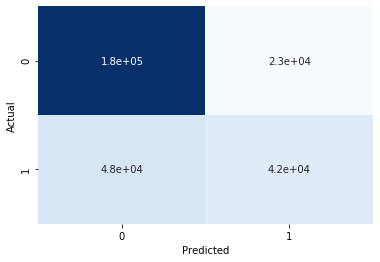

FOLD NUMBER =  9
Epoch 1/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.5121 - acc: 0.7326
Epoch 2/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4993 - acc: 0.7414
Epoch 3/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4940 - acc: 0.7454
Epoch 4/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4907 - acc: 0.7478
Epoch 5/10
2629629/2629629 [==============================] - 18s 7us/sample - loss: 0.4884 - acc: 0.7496
Epoch 6/10
2629629/2629629 [==============================] - 18s 7us/sample - loss: 0.4867 - acc: 0.7507
Epoch 7/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4853 - acc: 0.7519
Epoch 8/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4842 - acc: 0.7528
Epoch 9/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4834 - acc: 0.7534
Epoch 10/10
2629629/2629629 [

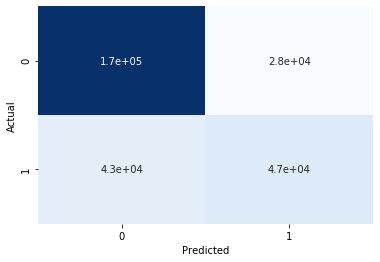

FOLD NUMBER =  10
Epoch 1/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.5122 - acc: 0.7324
Epoch 2/10
2629629/2629629 [==============================] - 18s 7us/sample - loss: 0.5001 - acc: 0.7413
Epoch 3/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4945 - acc: 0.7454
Epoch 4/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4908 - acc: 0.7479
Epoch 5/10
2629629/2629629 [==============================] - 17s 7us/sample - loss: 0.4882 - acc: 0.7494
Epoch 6/10
2629629/2629629 [==============================] - 18s 7us/sample - loss: 0.4864 - acc: 0.7508
Epoch 7/10
2629629/2629629 [==============================] - 18s 7us/sample - loss: 0.4851 - acc: 0.7518
Epoch 8/10
2629629/2629629 [==============================] - 18s 7us/sample - loss: 0.4840 - acc: 0.7525
Epoch 9/10
2629629/2629629 [==============================] - 18s 7us/sample - loss: 0.4831 - acc: 0.7534
Epoch 10/10
2629629/2629629 

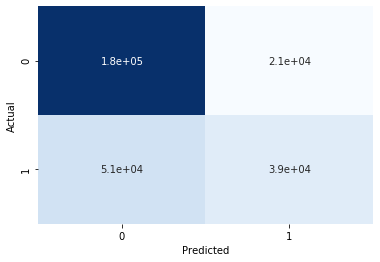

Fold  1  Accuracy:  0.7537622227317998
Fold  2  Accuracy:  0.7543919693614575
Fold  3  Accuracy:  0.7519345884913804
Fold  4  Accuracy:  0.7522186589819324
Fold  5  Accuracy:  0.7542208425599201
Fold  6  Accuracy:  0.7533446733360486
Fold  7  Accuracy:  0.7529271239402973
Fold  8  Accuracy:  0.7545767863071179
Fold  9  Accuracy:  0.7540668284385363
Fold  10  Accuracy:  0.753799870628138
Average Accuracy:  0.7535243564776628


In [5]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))
labels = data['Grouped_Severity']
#dropping percipitation and visibility due to all values removed as outliers
data = data.drop(["Grouped_Severity"], axis=1)

accuracies = Neural_Network(data,labels,85,10,10)
for i in range(1,11):
    print("Fold ",i," Accuracy: ",accuracies[i-1])
print("Average Accuracy: ",np.mean(accuracies))

In [ ]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

numeric_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']
data = outlier_removal(data,numeric_cols).reset_index(drop = True)

In [ ]:
#Boxplot after outlier removal
cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize=(15,20))
y = 0;
for name in cols[1:]:
    i, j = divmod(y, 2)
    sns.boxplot(x=data[name], ax=axes[i, j])
    y = y+1

plt.tight_layout()
plt.show()